### ATTENTION IS ALL YOU NEED_PAPER REVIEW

**1. Background & Motivation**
- Limitation: Seq2Seq, RNN, LSTM, CNN 모델들이 가진 구조적 한계점-순차적 연산으로 인한 병렬화 불가, 장기 의존성 문제
- Solution: Recurrence를 버리고 Attention만 쓰자. 

**2. Core Architecture**
- Positional Encoding: 왜 Sin/Cos 함수를 썼는가?
    - 상대적 위치 학습, 외삽성
- Scaled Dot-Product Attention: 왜 $\sqrt{d_k}$ 로 나누는가?
    - Softmax의 기울기 소실 방지
- Multi-Head Attention: 왜 여러 개의 헤드로 쪼개는가?
    - 다양한 문맥적 특징의 병렬 학습
- Masked Attention(Decoder): 미래의 단어를 미리 보는 것(Cheating)을 어떻게 방지하는가?

**3. Experiments & Results**
- 기존 모델(RNN/CNN) 대비 학습 시간(Complexity)과 성능(BLEU score) 비교

**4. Discussion & Limitations**
- Cons: 입력 시퀀스 길이의 제곱 $O(N^2)$ 에 비례하는 메모리 및 연산량 문제
    - 향후 Transformer의 가장 큰 과제

**5. Impact & Follow-ups**
- 해당 논문이 어떻게 BERT(Encoder-only), GPT(Decoder-only), ViT(Vision Transformer)로 파생되었는지 간략히 언급

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

- 데이터베이스의 검색 과정 중요.(Query-Key-Value)

In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [2]:
# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0)) # 학습되지 않는 상수로 등록

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [3]:
# 2. Scaled Dot-Product Attention
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size(-1)
    # Q와 K의 내적 후 스케일링
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    
    # 마스킹 (디코더에서 미래 정보 참조 방지 또는 패딩 무시)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, v)
    return output, attention_weights

In [4]:
# 3. Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        
        # 선형 변환 후 헤드 수에 맞게 차원 재배열
        q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 어텐션 계산 (attention_weights는 해석을 위해 반환)
        output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # 원래 차원으로 복구 및 Concat
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.out_proj(output), attention_weights

In [5]:
# 4. Feed-Forward Network
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

#### Application to Dataset: Toy Task

In [6]:
# (1) 데이터 임베딩 및 인코더 블록 구성 예시
class SimpleEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        
        # Self-Attention 블록
        attn_out, attn_weights = self.mha(x, x, x, mask)
        x = self.norm1(x + attn_out) # Add & Norm
        
        # Feed Forward 블록
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out) # Add & Norm
        return x, attn_weights

In [7]:
# (2) 실행 및 데이터셋 적용
vocab_size = 1000 # 단어 사전 크기
d_model = 512
num_heads = 8
seq_length = 10 # 문장 길이 (예: 10개의 단어)
batch_size = 32

# 임의의 토큰화된 문장 배치 (Batch)
# 실제로는 HuggingFace의 Tokenizer 등을 거친 결과값이 들어옵니다.
dummy_input = torch.randint(0, vocab_size, (batch_size, seq_length))

# 모델 선언 및 포워드 패스
encoder = SimpleEncoder(vocab_size, d_model, num_heads)
output, attention_weights = encoder(dummy_input)

print(f"Input Shape: {dummy_input.shape}") # (32, 10)
print(f"Output Shape: {output.shape}")     # (32, 10, 512) -> 각 단어가 512차원으로 문맥을 품은 벡터가 됨
print(f"Attention Weights Shape: {attention_weights.shape}") # (32, 8, 10, 10) -> (배치, 헤드수, 시퀀스길이, 시퀀스길이)

Input Shape: torch.Size([32, 10])
Output Shape: torch.Size([32, 10, 512])
Attention Weights Shape: torch.Size([32, 8, 10, 10])


#### Attention Map Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_attention_heads(attention_weights, batch_idx=0):
    # 1. 2행 4열의 서브플롯 생성 
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # 2. 2차원 배열(2x4)인 axes를 1차원으로 펴서 반복문 적용을 쉽게 만듦
    axes = axes.flatten()
    
    # 3. 8개의 헤드(0~7)에 대해 반복하며 히트맵 그리기
    for i in range(8):
        # 특정 헤드의 어텐션 가중치 추출
        attn_map = attention_weights[batch_idx, i].detach().numpy()
        
        # 각 subplot(axes[i])에 히트맵 그리기
        # (cbar=False로 설정해 개별 컬러바를 숨기면 훨씬 깔끔합니다)
        sns.heatmap(attn_map, cmap='viridis', cbar=False, ax=axes[i])
        
        # 각 subplot의 제목과 축 라벨 설정
        axes[i].set_title(f"Head {i+1}", fontsize=14, pad=10)
        axes[i].set_xlabel("Key Tokens")
        axes[i].set_ylabel("Query Tokens")
        
    # 4. 그래프 간 간격이 겹치지 않도록 자동 조절
    plt.tight_layout()
    plt.show()

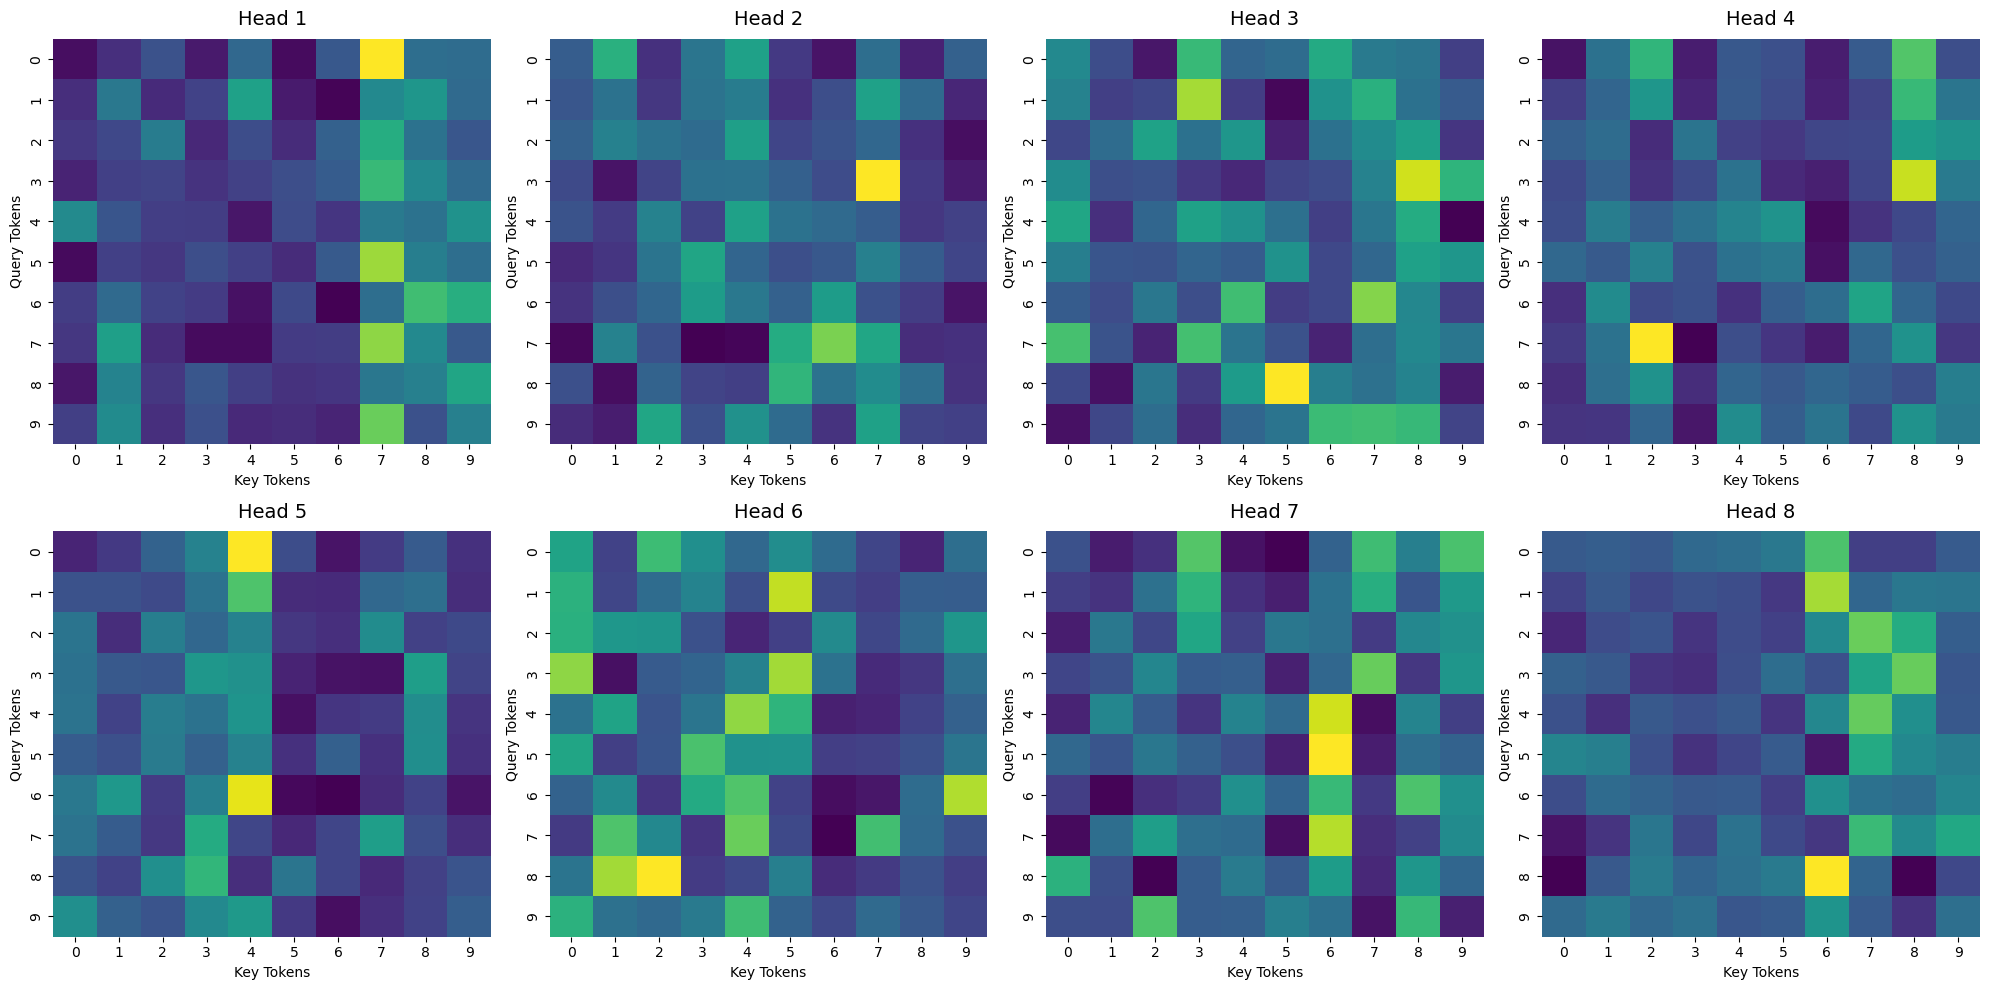

In [9]:
plot_all_attention_heads(attention_weights)

- Head 2는 *뚜렷한 대각선*을 보이며 인접한 단어의 **문법 구조**를 파악하고 있는 반면, 
- Head 5는 특정 단어들 사이의 점에 집중하며 *대명사의 지칭 대상*을 찾고 있음.

= 논문에서 강조한 Multi-Head Attention의 강점

= **다양한 문맥(Diverse Representation)의 병렬 학습**이 시각적으로 증명된 결과